Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Explore the data, transform and run alexnet with no tranfer learning using Adam optimiser

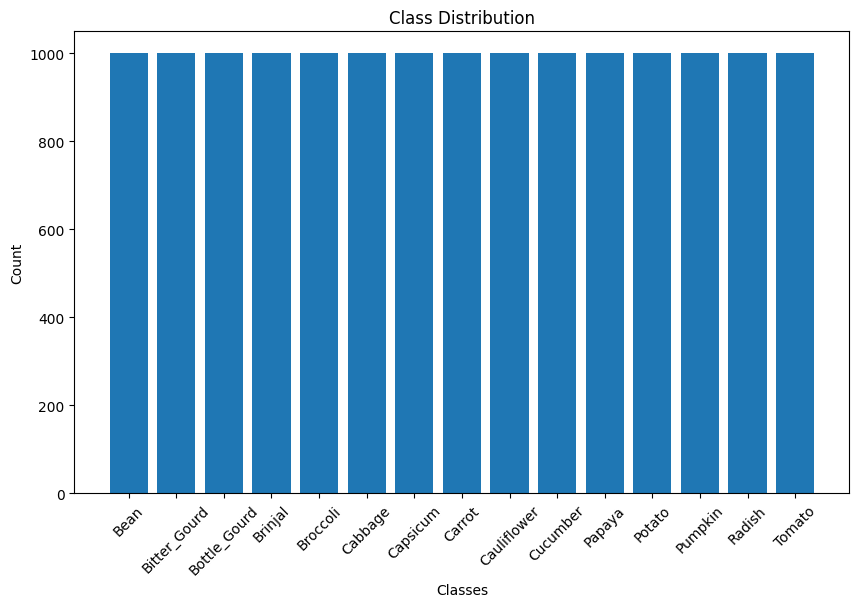

Class Distribution:
Bean: 1000 images
Bitter_Gourd: 1000 images
Bottle_Gourd: 1000 images
Brinjal: 1000 images
Broccoli: 1000 images
Cabbage: 1000 images
Capsicum: 1000 images
Carrot: 1000 images
Cauliflower: 1000 images
Cucumber: 1000 images
Papaya: 1000 images
Potato: 1000 images
Pumpkin: 1000 images
Radish: 1000 images
Tomato: 1000 images


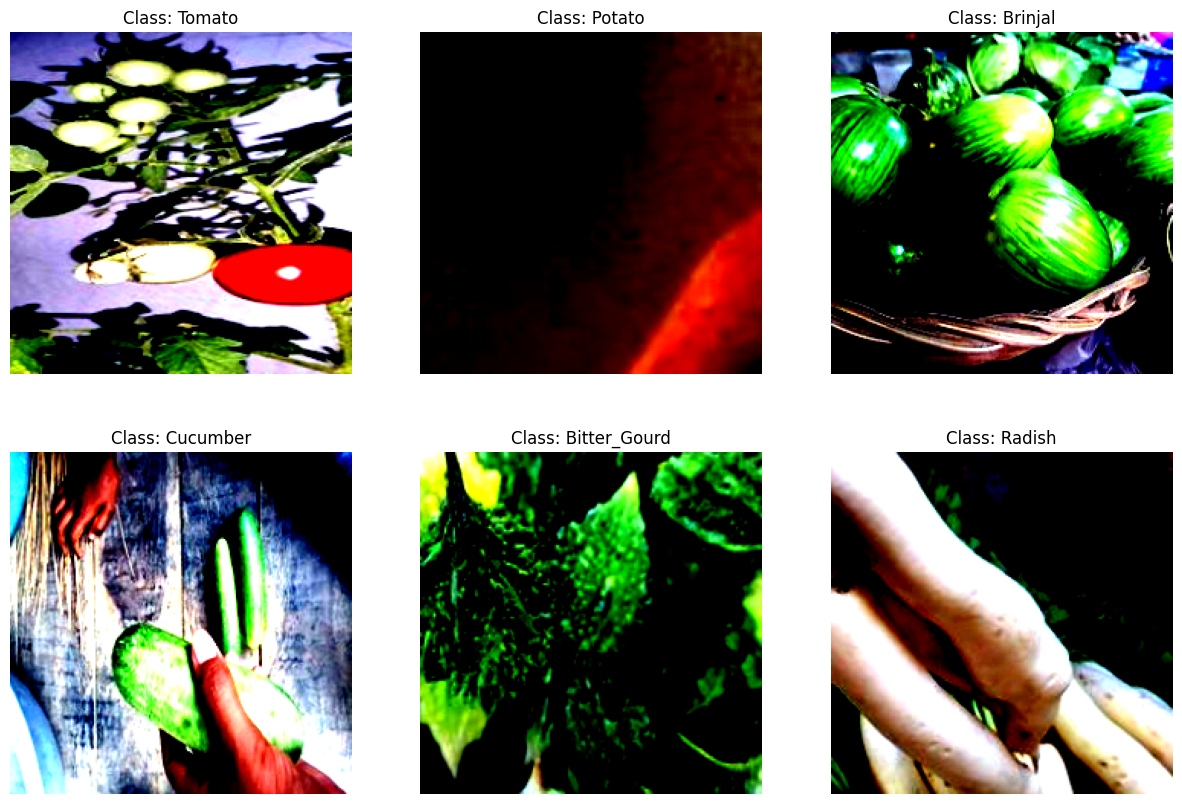

Epoch 1/10
----------
train Loss: 7151.6920 Acc: 0.0680
validation Loss: 2.7093 Acc: 0.0667
Epoch 2/10
----------
train Loss: 5.1575 Acc: 0.0649
validation Loss: 2.7105 Acc: 0.0667
Epoch 3/10
----------
train Loss: 2.7283 Acc: 0.0651
validation Loss: 2.7091 Acc: 0.0667
Epoch 4/10
----------
train Loss: 2.7131 Acc: 0.0626
validation Loss: 2.7093 Acc: 0.0667
Epoch 5/10
----------
train Loss: 2.7113 Acc: 0.0649
validation Loss: 2.7094 Acc: 0.0667
Epoch 6/10
----------
train Loss: 2.7120 Acc: 0.0637
validation Loss: 2.7098 Acc: 0.0667
Epoch 7/10
----------
train Loss: 2.7117 Acc: 0.0674
validation Loss: 2.7099 Acc: 0.0667
Epoch 8/10
----------
train Loss: 2.7108 Acc: 0.0667
validation Loss: 2.7097 Acc: 0.0667
Epoch 9/10
----------
train Loss: 2.7112 Acc: 0.0606
validation Loss: 2.7105 Acc: 0.0667
Epoch 10/10
----------
train Loss: 2.7103 Acc: 0.0675
validation Loss: 2.7095 Acc: 0.0667
Best validation Acc: 0.066667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.0667
Precision: 0.0044
Recall: 0.0667
F1 Score: 0.0083
Mean Loss: 2.7094


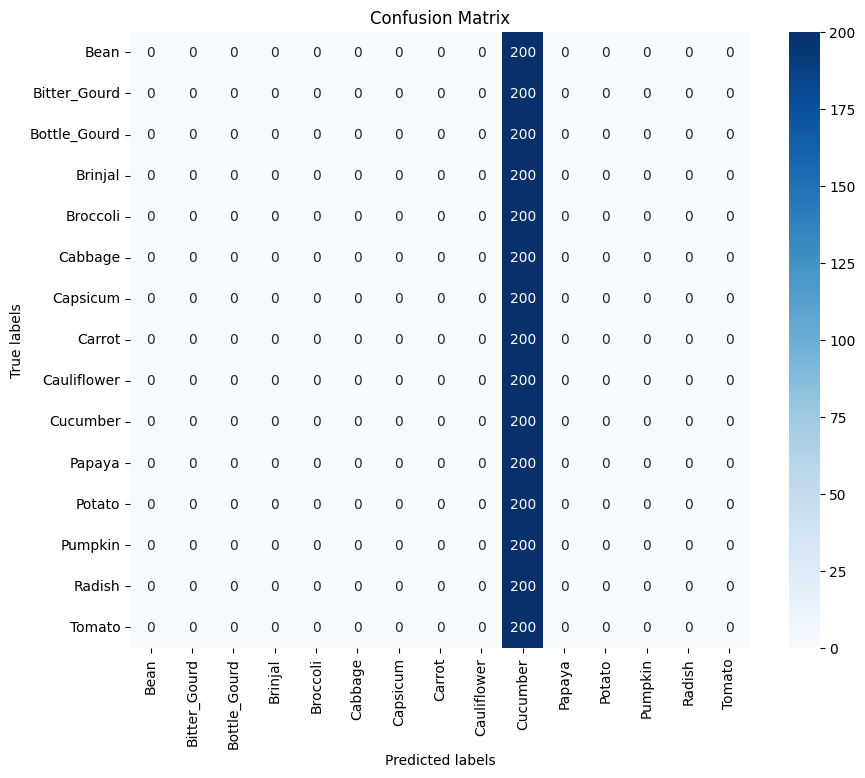

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Constants
DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'
BATCH_SIZE = 32
NUM_WORKERS = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.alexnet(pretrained=False)
    num_ftrs = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_ftrs, len(image_datasets['train'].classes))
    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print('Best validation Acc: {:4f}'.format(best_acc))

# Usage
image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

# Explore dataset after transform
def explore_dataset(dataset):
    class_names = dataset.classes
    class_counts = {class_name: 0 for class_name in class_names}

    for _, label in dataset:
        class_counts[class_names[label]] += 1

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)
    plt.show()

    print("Class Distribution:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    # Display sample images
    sample_loader = DataLoader(dataset, batch_size=6, shuffle=True)
    data_iter = iter(sample_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(15, 10))
    for i in range(6):
        plt.subplot(2, 3, i+1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'Class: {class_names[labels[i]]}')
        plt.axis('off')
    plt.show()

explore_dataset(image_datasets['train'])

# Train model
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)  # Using Adam optimizer
train_model(model, criterion, optimizer, num_epochs=10)

def evaluate_model(model, dataloader):
    """
    Evaluate the model on the given dataloader.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for test/validation data.

    Returns:
        Tuple of true labels and predicted labels.
    """
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, dataloaders['test'])

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot the confusion matrix.

    Args:
        conf_matrix (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)


Check if decreasing the learning rate makes a difference


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/10
----------
train Loss: 2.7256 Acc: 0.0621
validation Loss: 2.7081 Acc: 0.0667
Epoch 2/10
----------
train Loss: 2.7085 Acc: 0.0667
validation Loss: 2.7081 Acc: 0.0667
Epoch 3/10
----------
train Loss: 2.7085 Acc: 0.0592
validation Loss: 2.7081 Acc: 0.0667
Epoch 4/10
----------
train Loss: 2.7084 Acc: 0.0626
validation Loss: 2.7081 Acc: 0.0667
Epoch 5/10
----------
train Loss: 2.7084 Acc: 0.0647
validation Loss: 2.7081 Acc: 0.0667
Epoch 6/10
----------
train Loss: 2.7083 Acc: 0.0645
validation Loss: 2.7081 Acc: 0.0667
Epoch 7/10
----------
train Loss: 2.7084 Acc: 0.0641
validation Loss: 2.7081 Acc: 0.0667
Epoch 8/10
----------
train Loss: 2.7083 Acc: 0.0617
validation Loss: 2.7081 Acc: 0.0667
Epoch 9/10
----------
train Loss: 2.7084 Acc: 0.0586
validation Loss: 2.7081 Acc: 0.0667
Epoch 10/10
----------
train Loss: 2.7083 Acc: 0.0621
validation Loss: 2.7081 Acc: 0.0667
Best validation Acc: 0.066667


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test Accuracy: 0.0667
Precision: 0.0044
Recall: 0.0667
F1 Score: 0.0083
Mean Loss: 2.7081


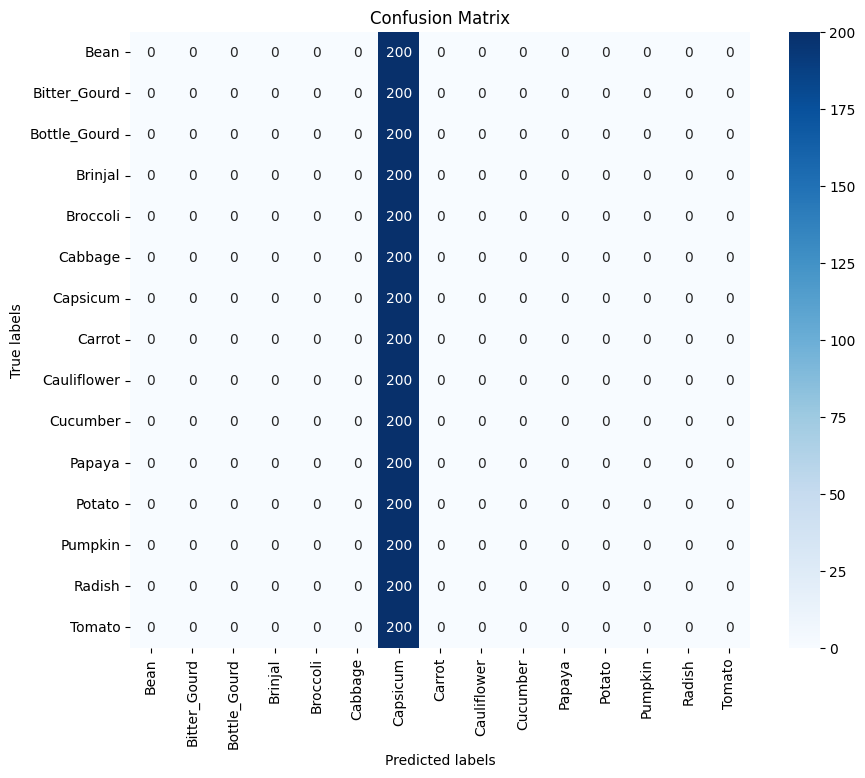

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Constants
DATA_DIRECTORY = '/content/drive/MyDrive/Vegetable Image Dataset/Vegetable Images'
BATCH_SIZE = 32
NUM_WORKERS = 2  # Adjust based on your system capabilities
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
}

def load_datasets():
    return {x: datasets.ImageFolder(os.path.join(DATA_DIRECTORY, x), data_transforms[x]) for x in ['train', 'validation', 'test']}

def create_dataloaders(image_datasets):
    return {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in ['train', 'validation', 'test']}

def setup_model():
    model = models.alexnet(pretrained=False)
    for param in model.parameters():
        param.requires_grad = True  # Set requires_grad to True for fine-tuning
    num_output_classes = len(image_datasets['train'].classes)
    model.classifier[6] = nn.Sequential(
        nn.Linear(4096, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, num_output_classes)  # Adding a new layer for classification
    )

    # Proper initialization of the additional layers
    for layer in model.classifier[6]:
        if isinstance(layer, nn.Linear):
            nn.init.xavier_uniform_(layer.weight)
            nn.init.zeros_(layer.bias)

    return model.to(device)

def train_model(model, criterion, optimizer, num_epochs=10):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc

    print('Best validation Acc: {:4f}'.format(best_acc))

# Usage
image_datasets = load_datasets()
dataloaders = create_dataloaders(image_datasets)
model = setup_model()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Reduced learning rate

train_model(model, criterion, optimizer, num_epochs=10)

def evaluate_model(model, dataloader):
    """
    Evaluate the model on the given dataloader.

    Args:
        model (nn.Module): The trained model.
        dataloader (DataLoader): DataLoader for test/validation data.

    Returns:
        Tuple of true labels and predicted labels.
    """
    model.eval()
    y_true = []
    y_pred = []
    losses = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            loss = criterion(outputs, labels)
            losses.append(loss.item())

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    mean_loss = np.mean(losses)

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Mean Loss: {mean_loss:.4f}')

    return y_true, y_pred

# Evaluate the model
y_true, y_pred = evaluate_model(model, dataloaders['test'])

def plot_confusion_matrix(conf_matrix, class_names):
    """
    Plot the confusion matrix.

    Args:
        conf_matrix (np.ndarray): Confusion matrix.
        class_names (list): List of class names.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
class_names = image_datasets['test'].classes
plot_confusion_matrix(conf_matrix, class_names)
